<a href="https://colab.research.google.com/github/treyra/CS155_miniproject3/blob/main/Indecision_Trees_Notebook_MiniProject_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This note book will run from top to bottom to produce all of the HMM results we report. Note that the preproccessing or training sections can be skipped and the results loaded from our github. Also note that there is a rare bug that we have been unable to reproduce in the HMM that may cause it to fail due to a variable being interpreted as a list instead of a int. Re-running the cell will fix the problem.

# Data Pre-processing



We start by loading in the data and processing it into a form that our algorithims can read. At the end of this section is a cell to load the final result in from our github

In [ ]:
import numpy as np
from tqdm.notebook import tqdm
import random

In [ ]:
# read in the data
# Import Data
data = np.genfromtxt('https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project3/data/shakespeare.txt',delimiter='\t',dtype=None,encoding='ISO-8859-1')
data[-15]

'154'

In [ ]:
# make all words lower case
for i in range(len(data)):
  data[i]=data[i].lower()

In [ ]:
# remove space at beginning of line
for i in range(len(data)):
  while data[i][0] == ' ':
    line = list(data[i])
    data[i] = "".join(line[1:len(line)])

In [ ]:
# remove \n
for i in range(len(data)):
        data[i] = data[i].replace('\n', '')

In [ ]:
# remove punctuation
to_remove = ['.', ',', ';', ':', '?', '!', '-', "'","(",")"]
for k in range(len(to_remove)):
  for i in range(len(data)):
    data[i] = ''.join([j for j in data[i] if j not in to_remove])

In [ ]:
# remove empty lines
# find indices to remove
remove_idx = []
for i in range(len(data)):
  if data[i] == '\n':
    remove_idx.append(i)
  if data[i] == '':
    remove_idx.append(i)
# remove
data_clean = []
for k in range(len(data)):
  if k not in remove_idx:
    data_clean.append(data[k])
data = data_clean

In [ ]:
# remove sonnets which are too long or too short
# always 14 lines long
# check how long each sonnet is - should be 14!
digit_idxs = []
for i in range(len(data)):
  if data[i].isdigit():
    digit_idxs.append(i)
#print(digit_idxs)
# get difference
length = np.diff(np.array(digit_idxs))
#print(length)
# remove the sonnet with too many or too few lines
remove_nbrs = dict()
for i in range(len(length)):
  if length[i]!=15:
    remove_nbrs.update({data[digit_idxs[i]]:length[i]})
# remove the sonnets with the numbers in remove_numbers
remove_idx = []
for i in range(len(data)):
  if data[i] in remove_nbrs:
    print(data[i])
    for k in range(0,remove_nbrs[data[i]]):
      remove_idx.append(i+k)
# remove
data_clean = []
for k in range(len(data)):
  if k not in remove_idx:
    data_clean.append(data[k])
data = data_clean

99
126


In [ ]:
# remove numbers
for i in range(len(data)):
  data[i] = ''.join([j for j in data[i] if not j.isdigit()])
# remove created empty lines again
# find indices to remove
remove_idx = []
for i in range(len(data)):
  if data[i] == '\n':
    remove_idx.append(i)
  if data[i] == '':
    remove_idx.append(i)
# remove
data_clean = []
for k in range(len(data)):
  if k not in remove_idx:
    data_clean.append(data[k])
data = data_clean

In [ ]:
# this is the data per line
data_by_line = data

In [ ]:
# get data per sonnet
# split up in sonnets
nr_sonnets = len(data)/14
data_by_sonnet = [None] * int(nr_sonnets)
i = 0
for k in range(0, len(data), 14):
  cString = ''
  for idx in range(14):
    #print(idx)
    if idx != 0:
      try:
        cString = cString + ' ' + data[k + idx]
      except:
        import pdb; pdb.set_trace()
    else: 
      cString = data[k]
  data_by_sonnet[i] = cString
  i+=1

## Load processed data
 
We can also load the pre-processed data directly as:

In [ ]:
# load the data
# open existing text file
data_sonnet_raw = np.genfromtxt('https://raw.githubusercontent.com/treyra/CS155_miniproject3/main/data/data_sonnet.txt',delimiter='\t',dtype=None,encoding='ISO-8859-1')
data_line = np.genfromtxt('https://raw.githubusercontent.com/treyra/CS155_miniproject3/main/data/data_line.txt',delimiter='\t',dtype=None,encoding='ISO-8859-1')

#HMM Model

Based off of HW 6's solution code

In [ ]:
class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0. 
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state. 
        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.
            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.
        Parameters:
            L:          Number of states.
            D:          Number of observations.
            
            A:          The transition matrix.
            
            O:          The observation matrix.
            
            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''

        self.L = len(A)
        self.D = len(O[0])
        self.A = np.array(A)
        self.O = np.array(O)
        self.A_start = [1. / self.L for _ in range(self.L)]


    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state 
        sequence corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            max_seq:    Output sequence corresponding to x with the highest
                        probability.
        '''

        M = len(x)      # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        #
        # For instance, probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.
        probs = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        seqs = [['' for _ in range(self.L)] for _ in range(M + 1)]

        # Calculate initial prefixes and probabilities.
        for curr in range(self.L):
            probs[1][curr] = self.A_start[curr] * self.O[curr][x[0]]
            seqs[1][curr] = str(curr)

        # Calculate best prefixes and probabilities throughout sequence.
        for t in range(2, M + 1):
            # Iterate over all possible current states.
            for curr in range(self.L):
                max_prob = float("-inf")
                max_prefix = ''

                # Iterate over all possible previous states to find one
                # that would maximize the probability of the current state.
                for prev in range(self.L):
                    curr_prob = probs[t - 1][prev] \
                                * self.A[prev][curr] \
                                * self.O[curr][x[t - 1]]

                    # Continually update max probability and prefix.
                    if curr_prob >= max_prob:
                        max_prob = curr_prob
                        max_prefix = seqs[t - 1][prev]

                # Store the max probability and prefix.
                probs[t][curr] = max_prob
                seqs[t][curr] = max_prefix + str(curr)

        # Find the index of the max probability of a sequence ending in x^M
        # and the corresponding output sequence.
        max_i = max(enumerate(probs[-1]), key=lambda x: x[1])[0]
        max_seq = seqs[-1][max_i]

        return max_seq


    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            alphas:     Vector of alphas.
                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.
                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        M = len(x)      # Length of sequence.
        alphas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        # Note that alpha_j(0) is already correct for all j's.
        # Calculate alpha_j(1) for all j's.
        for curr in range(self.L):
            alphas[1][curr] = self.A_start[curr] * self.O[curr][x[0]]

        # Calculate alphas throughout sequence.
        for t in range(1, M):
            # Iterate over all possible current states.
            for curr in range(self.L):
                prob = 0

                # Iterate over all possible previous states to accumulate
                # the probabilities of all paths from the start state to
                # the current state.
                for prev in range(self.L):
                    prob += alphas[t][prev] \
                            * self.A[prev][curr] \
                            * self.O[curr][x[t]]

                # Store the accumulated probability.
                alphas[t + 1][curr] = prob

            if normalize:
                norm = sum(alphas[t + 1])
                for curr in range(self.L):
                    alphas[t + 1][curr] /= norm

        return alphas


    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            betas:      Vector of betas.
                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.
                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)      # Length of sequence.
        betas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        # Initialize initial betas.
        for curr in range(self.L):
            betas[-1][curr] = 1

        # Calculate betas throughout sequence.
        for t in range(-1, -M - 1, -1):
            # Iterate over all possible current states.
            for curr in range(self.L):
                prob = 0

                # Iterate over all possible next states to accumulate
                # the probabilities of all paths from the end state to
                # the current state.
                for nxt in range(self.L):
                    if t == -M:
                        prob += betas[t][nxt] \
                                * self.A_start[nxt] \
                                * self.O[nxt][x[t]]

                    else:
                        prob += betas[t][nxt] \
                                * self.A[curr][nxt] \
                                * self.O[nxt][x[t]]

                # Store the accumulated probability.
                betas[t - 1][curr] = prob

            if normalize:
                norm = sum(betas[t - 1])
                for curr in range(self.L):
                    betas[t - 1][curr] /= norm

        return betas


    def supervised_learning(self, X, Y):
        '''
        Trains the HMM using the Maximum Likelihood closed form solutions
        for the transition and observation matrices on a labeled
        datset (X, Y). Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            Y:          A dataset consisting of state sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to L - 1. In other words, a list of
                        lists.
                        Note that the elements in X line up with those in Y.
        '''

        # Calculate each element of A using the M-step formulas.
        for curr in range(self.L):
            for nxt in range(self.L):
                num = 0.
                den = 0.

                for i in range(len(X)):
                    x = X[i]
                    y = Y[i]
                    M = len(x)
        
                    num += len([1 for i in range(M - 1) \
                                if y[i] == curr and y[i + 1] == nxt])
                    den += len([1 for i in range(M - 1) if y[i] == curr])

                self.A[curr][nxt] = num / den

        # Calculate each element of O using the M-step formulas.
        for curr in range(self.L):
            for xt in range(self.D):
                num = 0.
                den = 0.

                for i in range(len(X)):
                    x = X[i]
                    y = Y[i]
                    M = len(x)
        
                    num += len([1 for i in range(M) \
                                if y[i] == curr and x[i] == xt])
                    den += len([1 for i in range(M) if y[i] == curr])

                self.O[curr][xt] = num / den


    def unsupervised_learning(self, X, N_iters):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of length M, consisting of integers ranging
                        from 0 to D - 1. In other words, a list of lists.
            N_iters:    The number of iterations to train on.
        '''

        # Note that a comment starting with 'E' refers to the fact that
        # the code under the comment is part of the E-step.

        # Similarly, a comment starting with 'M' refers to the fact that
        # the code under the comment is part of the M-step.

        for iteration in tqdm(range(1, N_iters + 1)):
            if iteration % 10 == 0:
                print("Iteration: " + str(iteration))

            # Numerator and denominator for the update terms of A and O.
            A_num = [[0. for i in range(self.L)] for j in range(self.L)]
            O_num = [[0. for i in range(self.D)] for j in range(self.L)]
            A_den = [0. for i in range(self.L)]
            O_den = [0. for i in range(self.L)]

            # For each input sequence:
            for x in X:
                M = len(x)
                # Compute the alpha and beta probability vectors.
                alphas = self.forward(x, normalize=True)
                betas = self.backward(x, normalize=True)

                # E: Update the expected observation probabilities for a
                # given (x, y).
                # The i^th index is P(y^t = i, x).
                for t in range(1, M + 1):
                    P_curr = [0. for _ in range(self.L)]
                    
                    for curr in range(self.L):
                        P_curr[curr] = alphas[t][curr] * betas[t][curr]

                    # Normalize the probabilities.
                    norm = sum(P_curr)
                    for curr in range(len(P_curr)):
                        P_curr[curr] /= norm

                    for curr in range(self.L):
                        if t != M:
                            A_den[curr] += P_curr[curr]
                        O_den[curr] += P_curr[curr]
                        O_num[curr][x[t - 1]] += P_curr[curr]

                # E: Update the expectedP(y^j = a, y^j+1 = b, x) for given (x, y)
                for t in range(1, M):
                    P_curr_nxt = [[0. for _ in range(self.L)] for _ in range(self.L)]

                    for curr in range(self.L):
                        for nxt in range(self.L):
                            P_curr_nxt[curr][nxt] = alphas[t][curr] \
                                                    * self.A[curr][nxt] \
                                                    * self.O[nxt][x[t]] \
                                                    * betas[t + 1][nxt]

                    # Normalize:
                    norm = 0
                    for lst in P_curr_nxt:
                        norm += sum(lst)
                    for curr in range(self.L):
                        for nxt in range(self.L):
                            P_curr_nxt[curr][nxt] /= norm

                    # Update A_num
                    for curr in range(self.L):
                        for nxt in range(self.L):
                            A_num[curr][nxt] += P_curr_nxt[curr][nxt]

            for curr in range(self.L):
                for nxt in range(self.L):
                    self.A[curr][nxt] = A_num[curr][nxt] / A_den[curr]

            for curr in range(self.L):
                for xt in range(self.D):
                    self.O[curr][xt] = O_num[curr][xt] / O_den[curr]

    def generate_emission(self, M):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random. 
        Arguments:
            M:          Length of the emission to generate.
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
        '''

        emission = []
        state = random.choice(range(self.L))
        states = []

        for t in range(M):
            # Append state.
            states.append(state)

            # Sample next observation.
            rand_var = random.uniform(0, 1)
            next_obs = 0

            while rand_var > 0:
                rand_var -= self.O[state][next_obs]
                next_obs += 1

            next_obs -= 1
            emission.append(next_obs)

            # Sample next state.
            rand_var = random.uniform(0, 1)
            next_state = 0

            while rand_var > 0:
                rand_var -= self.A[state][next_state]
                next_state += 1

            next_state -= 1
            state = next_state

        return emission, states


    def probability_alphas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the forward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the output sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any output sequence, i.e. the
        # probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(0) gives the probability of the output sequence. Summing
        # this over all states and then normalizing gives the total
        # probability of x paired with any output sequence, i.e. the
        # probability of x.
        prob = sum([betas[1][k] * self.A_start[k] * self.O[k][x[0]] \
            for k in range(self.L)])

        return prob


def supervised_HMM(X, Y):
    '''
    Helper function to train a supervised HMM. The function determines the
    number of unique states and observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for supervised learning.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        Y:          A dataset consisting of state sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to L - 1. In other words, a list of lists.
                    Note that the elements in X line up with those in Y.
    '''

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Make a set of states.
    states = set()
    for y in Y:
        states |= set(y)
    
    # Compute L and D.
    L = len(states)
    D = len(observations)

    # Randomly initialize and normalize matrices A and O.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with labeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.supervised_learning(X, Y)

    return HMM


def unsupervised_HMM(X, n_states, N_iters,rng=np.random.RandomState(1)):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        n_states:   Number of hidden states to use in training.
        
        N_iters:    The number of iterations to train on.
        rng:        The random number generator for reproducible result.
                    Default to RandomState(1).
    '''

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)
    
    # Compute L and D.
    L = n_states
    D = len(observations)

    # Randomly initialize and normalize matrices A.
    A = [[rng.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[rng.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM

In [ ]:
########################################
# CS/CNS/EE 155 2018
# Problem Set 6
#
# Author:       Andrew Kang
# Description:  Set 6 HMM helper
########################################

import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation


####################
# WORDCLOUD FUNCTIONS
####################

def mask():
    # Parameters.
    r = 128
    d = 2 * r + 1

    # Get points in a circle.
    y, x = np.ogrid[-r:d-r, -r:d-r]
    circle = (x**2 + y**2 <= r**2)

    # Create mask.
    mask = 255 * np.ones((d, d), dtype=np.uint8)
    mask[circle] = 0

    return mask

def text_to_wordcloud(text, max_words=50, title='', show=True, stopwrds = True):
    plt.close('all')
    # modified here to include possible empty set as stop words
    # Generate a wordcloud image.
    if not stopwrds:
      wordcloud = WordCloud(stopwords = set(), 
                            random_state=0,
                            max_words=max_words,
                            background_color='white',
                            mask=mask()).generate(text)
    else:
      wordcloud = WordCloud(random_state=0,
                            max_words=max_words,
                            background_color='white',
                            mask=mask()).generate(text)

    # Show the image.
    if show:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=24)
        plt.show()

    return wordcloud

def states_to_wordclouds(hmm, obs_map, max_words=50, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))

    return wordclouds


####################
# HMM FUNCTIONS
####################

def parse_observations(text):
    # Convert text to dataset.
    lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []
        
        for word in line:
            word = re.sub(r'[^\w]', '', word).lower()
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1
            
            # Add the encoded word.
            obs_elem.append(obs_map[word])
        
        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

def sample_sentence(hmm, obs_map, n_words=100):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    # Sample and convert sentence.
    emission, states = hmm.generate_emission(n_words)
    sentence = [obs_map_r[i] for i in emission]

    return ' '.join(sentence).capitalize() + '...'


####################
# HMM VISUALIZATION FUNCTIONS
####################

def visualize_sparsities(hmm, O_max_cols=50, O_vmax=0.1):
    plt.close('all')
    plt.set_cmap('viridis')

    # Visualize sparsity of A.
    plt.imshow(hmm.A, vmax=1.0)
    plt.colorbar()
    plt.title('Sparsity of A matrix')
    plt.show()

    # Visualize parsity of O.
    plt.imshow(np.array(hmm.O)[:, :O_max_cols], vmax=O_vmax, aspect='auto')
    plt.colorbar()
    plt.title('Sparsity of O matrix')
    plt.show()


####################
# HMM ANIMATION FUNCTIONS
####################

def animate_emission(hmm, obs_map, M=8, height=12, width=12, delay=1):
    # Parameters.
    lim = 1200
    text_x_offset = 40
    text_y_offset = 80
    x_offset = 580
    y_offset = 520
    R = 420
    r = 100
    arrow_size = 20
    arrow_p1 = 0.03
    arrow_p2 = 0.02
    arrow_p3 = 0.06
    
    # Initialize.
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = states_to_wordclouds(hmm, obs_map, max_words=20, show=False)

    # Initialize plot.    
    fig, ax = plt.subplots()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax.grid('off')
    plt.axis('off')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])

    # Plot each wordcloud.
    for i, wordcloud in enumerate(wordclouds):
        x = x_offset + int(R * np.cos(np.pi * 2 * i / n_states))
        y = y_offset + int(R * np.sin(np.pi * 2 * i / n_states))
        ax.imshow(wordcloud.to_array(), extent=(x - r, x + r, y - r, y + r), aspect='auto', zorder=-1)

    # Initialize text.
    text = ax.text(text_x_offset, lim - text_y_offset, '', fontsize=24)
        
    # Make the arrows.
    zorder_mult = n_states ** 2 * 100
    arrows = []
    for i in range(n_states):
        row = []
        for j in range(n_states):
            # Arrow coordinates.
            x_i = x_offset + R * np.cos(np.pi * 2 * i / n_states)
            y_i = y_offset + R * np.sin(np.pi * 2 * i / n_states)
            x_j = x_offset + R * np.cos(np.pi * 2 * j / n_states)
            y_j = y_offset + R * np.sin(np.pi * 2 * j / n_states)
            
            dx = x_j - x_i
            dy = y_j - y_i
            d = np.sqrt(dx**2 + dy**2)

            if i != j:
                arrow = ax.arrow(x_i + (r/d + arrow_p1) * dx + arrow_p2 * dy,
                                 y_i + (r/d + arrow_p1) * dy + arrow_p2 * dx,
                                 (1 - 2 * r/d - arrow_p3) * dx,
                                 (1 - 2 * r/d - arrow_p3) * dy,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))
            else:
                arrow = ax.arrow(x_i, y_i, 0, 0,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))

            row.append(arrow)
        arrows.append(row)

    emission, states = hmm.generate_emission(M)

    def animate(i):
        if i >= delay:
            i -= delay

            if i == 0:
                arrows[states[0]][states[0]].set_color('red')
            elif i == 1:
                arrows[states[0]][states[0]].set_color((1 - hmm.A[states[0]][states[0]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')
            else:
                arrows[states[i - 2]][states[i - 1]].set_color((1 - hmm.A[states[i - 2]][states[i - 1]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')

            # Set text.
            text.set_text(' '.join([obs_map_r[e] for e in emission][:i+1]).capitalize())

            return arrows + [text]

    # Animate!
    print('\nAnimating...')
    anim = FuncAnimation(fig, animate, frames=M+delay, interval=1000)

    return anim

# Generating the syllable dictionary

In [ ]:
!wget https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project3/data/Syllable_dictionary.txt

--2021-03-11 04:13:41--  https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project3/data/Syllable_dictionary.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33379 (33K) [text/plain]
Saving to: ‘Syllable_dictionary.txt’

Syllable_dictionary 100%[===================>]  32.60K  --.-KB/s    in 0.005s  

2021-03-11 04:13:41 (6.75 MB/s) - ‘Syllable_dictionary.txt’ saved [33379/33379]



In [ ]:
import re
import numpy as np
with open('Syllable_dictionary.txt', "r") as f:
  syl_data = f.readlines()
f.close()
with open('Syllable_dictionary.txt', "r") as f:
  syl_data_original = f.readlines()
f.close()

In [ ]:
from nltk.tokenize import WhitespaceTokenizer

# remove all ' or " and \n
for i in range(len(syl_data_original)):
  syl_data_original[i] = syl_data_original[i].replace('\n', '')
# split the lines into words
for i in range(len(syl_data_original)):
  syl_data_original[i] = WhitespaceTokenizer().tokenize(syl_data_original[i])

In [ ]:
# remove all ' or " and \n
# remove punctuation
to_remove = ['-', "'"]
for k in range(len(to_remove)):
  for i in range(len(syl_data)):
    #print(syl_data[i])
    syl_data[i] = ''.join([j for j in syl_data[i] if j not in to_remove])
for i in range(len(syl_data)):
  syl_data[i] = syl_data[i].replace('\n', '')
# split the lines into words
for i in range(len(syl_data)):
  syl_data[i] = re.findall(r"[\w']+|[.,?;]", syl_data[i])
# make syl_data a dictionary
syl_dict = dict()
for line in syl_data:
  syl_dict.update({line[0]: [line[i] for i in range(1, len(line))]})

In [ ]:
# create the comparison dictionary
comp_dict = dict()
for row in syl_data_original:
  to_remove = ['-', "'"]
  mod = ''.join([j for j in row[0] if j not in to_remove])
  comp_dict.update({mod: row[0]})
# add the conversion from i to I
comp_dict.update({'i': 'I'})

# **Generating Random Sonnets**

Extend the HMM class to include the sonnet generation

## SonnetHiddenMarkovModel

In [ ]:
class SonnetHiddenMarkovModel ( HiddenMarkovModel ):
    '''
    Class implementation of Hidden Markov Models for rhyming sonnets
    '''

    def __init__(self, A, O,syl_dict,obs_map,comp_dict):
        
        self.comp_dict = comp_dict
        self.syl_dict = syl_dict
        self.obs_map = obs_map
        self.obs_map_r = obs_map_reverser(obs_map)
        HiddenMarkovModel.__init__(self,A,O)


    def generate_sonnet(self):
        # now generate a random sonnet with 14 lines and 10 syllables each
        emission = []
        states = []
        # make sure we have 14 lines
        line_syls = []
        for i in range(0,14):
          # each line with 10 syllables
          emission = []
          states = []
          k = 0
          # Initial state
          states.append(np.random.randint(0,self.L))
          emission.append(np.random.choice(self.D,None, True, self.O[states[0],:]))
          syl_count= syl_dict[self.obs_map_r[emission[0]]]
          if len(syl_count)>1:
            # check to use the one not at the end or just randomly
            not_end_count = [x for x in syl_count if not x.startswith('E')]
            syl_count = not_end_count
            # if syl_count[0][0]!='E':
            #   syl_count = syl_count[0][0]
          try:
            k+=int(syl_count[0])
          except:
            import pdb; pdb.set_trace()
          j=0
          #print(k)
          while k<10:
            #import pdb; pdb.set_trace()
            j+=1
            # generate next word
            states.append(np.random.choice(self.L,None, True, self.A[states[j-1],:]))
            emission.append(np.random.choice(self.D,None, True, self.O[states[j],:]))
            syl_count= syl_dict[self.obs_map_r[emission[j]]]
            #print(self.obs_map_r[emission[j]])
            if len(syl_count)>1:
              end_count = [x for x in syl_count if x.startswith('E')]
              #import pdb; pdb.set_trace()
              if len(end_count) >= 1:
                if k + int(end_count[0][-1]) > 10:
                  # if equal to 10 pick this word and save sentence
                  if k + int(end_count[0][-1]) == 10:
                    syl_count=int(end_count[0][-1])
                # check to use the correct one
                else:
                  for s in syl_count:
                    if s[0]!='E':
                      syl_count = int(s)
              else:
                syl_count = int(syl_count[0])
            else:
              syl_count = int(syl_count[0])
            if k+syl_count>10:
              # regernerate
              while k+syl_count>10:
                states[j] = (np.random.choice(self.L,None, True, self.A[states[j-1],:]))
                emission[j] = (np.random.choice(self.D,None, True, self.O[states[j],:]))
                syl_count= syl_dict[self.obs_map_r[emission[j]]]
                end_count = [x for x in syl_count if x.startswith('E')]
                if len(end_count) >= 1:
                  syl_count=int(end_count[0][-1])
                else:
                  syl_count = int(syl_count[0])
            try:
              k+=syl_count # or just pick the first one
            except:
              import pdb; pdb.set_trace()
            #print(k)
            if k>=10:
              line_syls.append(k)
          sentence = [self.comp_dict[self.obs_map_r[emission[i]]].capitalize() if i==0 else self.comp_dict[self.obs_map_r[emission[i]]] for i in range(len(emission))]
          print(' '.join(sentence))
          # break the line after 4/8/12 lines
          if (i == 3 or i == 7 or i == 11):
            print('\n')
        print(line_syls)

Now input data and train HMM

Modify raw text data into data we can use for our syllable dictionary

## Modify data for training

In [ ]:
data_sonnet = [[]]
for i,sonnet in enumerate(data_sonnet_raw):
    data_sonnet[i] = sonnet.split()
    if i != len(data_sonnet_raw)-1:
        data_sonnet.append([])

In [ ]:
# create obs map
count = 0
obs = []
obs_map = {}

for line in data_sonnet:
  obs_line = []
  for word in line:
    if word not in obs_map:
      # add new words to the map
      obs_map[word] = count
      count += 1
    # add the encoded words to the line map
    obs_line.append(obs_map[word])
      
    # add the encoded sequence
  obs.append(obs_line)

In [ ]:
# train a HMM (only a few epochs)
hmm5 = unsupervised_HMM(obs, 5, 50)

# #Save to drive
#np.save('/content/drive/My Drive/CS155_miniproject_3/5_50_A.npy', hmm5.A)    
#np.save('/content/drive/My Drive/CS155_miniproject_3/5_50_O.npy', hmm5.O)    

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50



## Load pre-trained HMMs and generate sonnets

To save time, we trained HMMs with 5, 10, 15, and 20 states and saved them to our git hub, we can now load the A and O matricies and generate sonnets directly

One indirectly buried sweet tell her
That to thy men bastard new but all did
Didst would admire how a is lends eyes bonds
That do graves do rude since said common parts


For do restful self therefore thing hate I
Reigns thou the the longer forty what in
Self evil happy rigour loving I
Should you use therefore the of and to had


Is I borrowed but sure nights falsely a
Change why word then when the willingly same
Invention saith applying and sort proud
Out from sealed and are purity these thine


Whose yet to my canker save up trespass
In to each dost well the which hungry gave
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


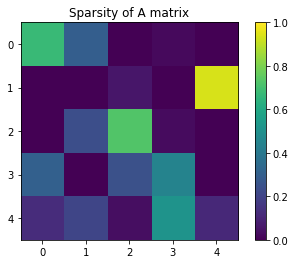

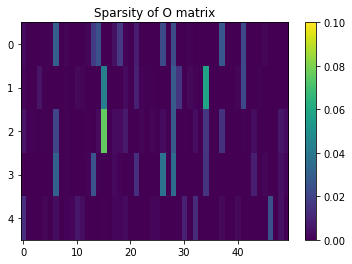

In [ ]:
import requests
import io

response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/5_50_A.npy?raw=true')
response.raise_for_status()
loadA = np.load(io.BytesIO(response.content))  
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/5_50_O.npy?raw=true')
response.raise_for_status()
loadO = np.load(io.BytesIO(response.content)) 
hmm5 = SonnetHiddenMarkovModel(loadA, loadO,syl_dict,obs_map,comp_dict)
hmm5.generate_sonnet()

visualize_sparsities(hmm5, O_max_cols=50)

Wish it be dead the sweet worthy of leaves
Of be dignifies writ it now the oaths
True accuse thou art my think gates but my
Depart this much shouldst dost live record my


You thee that worst did thee and you keen be
The height sway to idly did new still which
Nor our for and moon sorrows thy bath I
No shall fresher false as their false-speaking


World I am not old not muse sweet self to
Queen and that the clear oaths laid thy sweet being
Shake to thing sins I me call use and thou
Sighs shouldst when they days found in shall a false


If barren let salutation now my
Affairs all thine eyes hammered strongly I
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


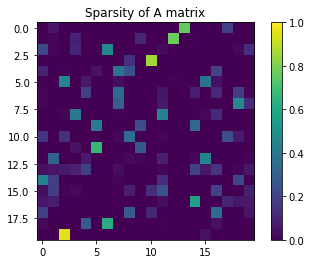

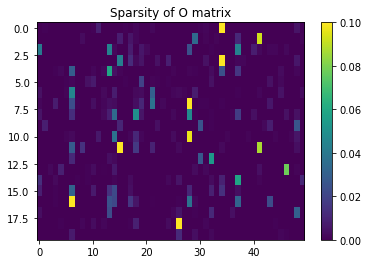

In [ ]:
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/20_50_A.npy?raw=true')
response.raise_for_status()
loadA = np.load(io.BytesIO(response.content))  
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/20_50_O.npy?raw=true')
response.raise_for_status()
loadO = np.load(io.BytesIO(response.content)) 
hmm20 = SonnetHiddenMarkovModel(loadA, loadO,syl_dict,obs_map,comp_dict)
hmm20.generate_sonnet()

visualize_sparsities(hmm20, O_max_cols=50)

To the disposed from my it count love by
Do as speak your and for but from mine which
Night a and melancholy in have worst
Is checked fair hath honour hairs might make thee


In found that thought with give by makes straight say
Her in the wear wet beauteous to nearly
Tenure is you o other my my no
I thy large eyes or jewel while what white


Thee hast excuse in a crime will no dear
And and thus on a or find this for of
Issue thou youth surmise injurious my
Trust dead day pale they are high beauty on


I renewest be chief self it his groan
With that beauty whether desire rise thought might
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


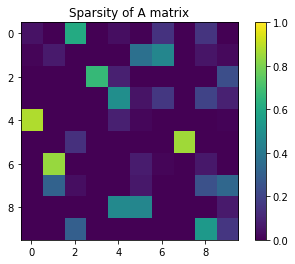

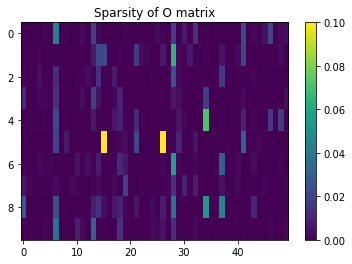

In [ ]:
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/10_50_A.npy?raw=true')
response.raise_for_status()
loadA = np.load(io.BytesIO(response.content))  
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/10_50_O.npy?raw=true')
response.raise_for_status()
loadO = np.load(io.BytesIO(response.content)) 
hmm10 = SonnetHiddenMarkovModel(loadA, loadO,syl_dict,obs_map,comp_dict)
hmm10.generate_sonnet()

visualize_sparsities(hmm10, O_max_cols=50)

Not thou quite absent subject sooner of
To pale masked not to see there best and ill
Granting from told for mine since I of you
Slander straight green the time year o would must


In the given wanton come just pale breath in
Make one and to thy blot thy dead great power
Youth so must more whose of into for th' faith
That more true injuries dark more good cries


Recounting heat the most fresh grace it pitch
Where death a is the pitch all-eating joy
Of ill prisoner wiry the the story
And should art so time wilt heaven to with am


For thou winters find my thy air hath will
To spends in for it men upon shame you
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


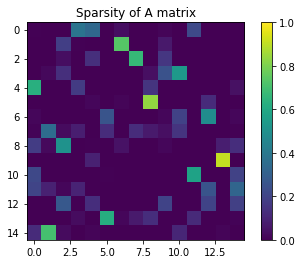

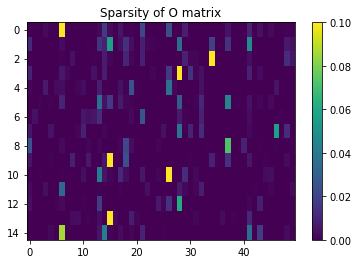

In [ ]:
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/15_50_A.npy?raw=true')
response.raise_for_status()
loadA = np.load(io.BytesIO(response.content))  
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/15_50_O.npy?raw=true')
response.raise_for_status()
loadO = np.load(io.BytesIO(response.content)) 
hmm15 = SonnetHiddenMarkovModel(loadA, loadO,syl_dict,obs_map,comp_dict)
hmm15.generate_sonnet()

visualize_sparsities(hmm15, O_max_cols=50)

# **Rhyming HMM**

Loading the rhyming dictionary made using the example rhymes in the training data

In [ ]:
# Loading from our github
rhyme_array_raw = np.genfromtxt('https://raw.githubusercontent.com/treyra/CS155_miniproject3/main/data/rhyme_list.txt',delimiter='\t',dtype=None,encoding='ISO-8859-1')

rhyme_array = np.zeros((len(rhyme_array_raw),2),dtype=object)
for i,rhymes in enumerate(rhyme_array_raw):
    #Stored as a np array written to a text file, so remove the brackets
    rhyme_array[i,0] = rhymes.split()[0][2:-1]
    rhyme_array[i,1] = rhymes.split()[1][1:-2]

In [ ]:
class RhymingHiddenMarkovModel ( HiddenMarkovModel ):
    '''
    Class implementation of Hidden Markov Models for rhyming sonnets
    '''

    def __init__(self, A, O,rhyme_array,syl_dict,obs_map,comp_dict):
        self.comp_dict = comp_dict
        self.rhyme_array = rhyme_array
        self.syl_dict = syl_dict
        self.obs_map = obs_map
        self.obs_map_r = obs_map_reverser(obs_map)
        HiddenMarkovModel.__init__(self,A,O)

    def emit_line(self, numSyls = 10, endSeed=None):
        """
        Generate a random line backwards to forwards
        using a seeded ending word, if provided
        Parameters
        ----------
        numSyls : int
            Number of syllables the line should have. 
            Default is 10
        endSeed : tuple (int,string)
            The HMM state and the string the line will
            end in, if any.
        """
        #Line to emit
        line = None 

        #No seed, pick random initial state
        if endSeed is None:
            state = np.random.randint(0,self.L)
            line = np.array([np.random.choice(self.D,p=self.O[state,:])])
        else:
            state = endSeed[0]
            line = np.array([self.obs_map[endSeed[1]]])
        k = 0
        # Initial state
        syl_count= syl_dict[self.obs_map_r[line[0]]]
        if len(syl_count)>1:
          # check to use the one not at the end or just randomly
          not_end_count = [x for x in syl_count if not x.startswith('E')]
          syl_count = not_end_count
          # if syl_count[0][0]!='E':
          #   syl_count = syl_count[0][0]
        try:
          k+=int(syl_count[0])
        except:
          import pdb; pdb.set_trace()
        #Now loop backwards and generate rest of line before word
        j = 0
        prevState = state
        while k < 10:
            j+=1
            # generate next word (NOTE: we must train the A matrix on backward
            # strings of sonnet lines for this to work, as we are going the opposite direction now)
            state = np.random.choice(self.L,p= self.A[prevState,:])
            line = np.concatenate(([np.random.choice(self.D,p=self.O[state,:])],line)) 
            syl_count= syl_dict[self.obs_map_r[line[0]]]
            #print(obs_map_r[line[0]])
            if len(syl_count)>1:
              end_count = [x for x in syl_count if x.startswith('E')]
              if len(end_count) >= 1:
                if k + int(end_count[0][-1]) > 10:
                  # if equal to 10 pick this word and save sentence
                  if k + int(end_count[0][-1]) == 10:
                    syl_count=int(end_count[0][-1])
                # check to use the correct one
                else:
                  for s in syl_count:
                    if s[0]!='E':
                      syl_count = int(s)
              else:
                syl_count = int(syl_count[0])
            else:
              syl_count = int(syl_count[0])
            if k+syl_count>10:
              # regernerate
              while k+syl_count>10:
                state = np.random.choice(self.L,p= self.A[prevState,:])
                line[0] = (np.random.choice(self.D,p = self.O[state,:]))
                syl_count= syl_dict[self.obs_map_r[line[0]]]
                end_count = [x for x in syl_count if x.startswith('E')]
                if len(end_count) >= 1:
                  syl_count=int(end_count[0][-1])
                else:
                  syl_count = int(syl_count[0])
            try:
              k+=syl_count # or just pick the first one
            except:
              import pdb; pdb.set_trace()
            #print(k)
            if k>=10:
              return [self.obs_map_r[i] for i in line]
    def genRhymingSonnet(self):
        """
        Uses rhyme dict to seed lines for a rhyming sonnet
        """
        sonnet = np.array([[]],dtype=object)
        #Generate 14 rhyming lines
        #List of indicies already picked and the word in the pair used
        #(set to -1 initially)
        used = np.zeros((7,2)) - 1

        for i in range(14):
            #Let the first word in the rhyme pair be in any order
            firstWord = -1
            if i == 0 or i == 1 or i == 4 or i == 5 or i == 8 or i == 9 or i == 12:
                rhyme = np.random.randint(0,len(self.rhyme_array))
                #Redraw for uniqueness (desired behavior?)
                while rhyme in used:
                    rhyme = np.random.randint(0,len(self.rhyme_array))
                #Using integer math to get the right index for each pair of rhymes
                used[int((i+1)/2),0] = rhyme
                #Randomly draw the last word, save so we use other next time
                lastWord = np.random.randint(0,len(self.rhyme_array[rhyme]))
                used[int((i+1)/2),1] = lastWord
            else:
                #Using integer math to get the right index for each pair of rhymes
                rhyme = int(used[int((i-1)/2),0])
                #Get the other word in pair (this is to allow for N lenght lists of rhymes)
                lastWord = np.random.randint(0,len(self.rhyme_array[rhyme])-1)
                #If we got the word we already used, just assign the one we excluded from the draw
                if lastWord == used[int((i-1)/2),1]:
                    lastWord = len(self.rhyme_array[rhyme])-1
                lastWord = int(lastWord)
            line = self.emit_line(endSeed=(np.random.randint(0,self.L),self.rhyme_array[rhyme,lastWord]))
            sent= [self.comp_dict[line[i]].capitalize() if i==0 else self.comp_dict[line[i]] for i in range(len(line))]
            print(i,end = ": ")
            print(' '.join(sent))
            sonnet = np.append(sonnet,sent)           
        return sonnet


## Training Rhyming HMMs

To train the rhymming HMM, we need to flip the input data lines/sonnets around

This example is for the full sonnet



In [ ]:
rhyming_obs = []
for i in range(len(obs)):
    rhyming_obs.append(obs[i][::-1])

In [ ]:
# train a HMM (only a few epochs)
rhymingHMM_20 = unsupervised_HMM(rhyming_obs, 20, 50)

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50



## Load pre-trained rhyming HMMS and generate sonnets

0: When pain it thou though come verse when I hide
1: Esteem be say thee to those you heart art
2: With the thine art earth you eat tract that pride
3: You from while more if compare curious heart
4: And full decree painter's to thy much thee
5: That each and fair how linger thy though not
6: Truth o more mayst me have my whilst my be
7: What one I I doth checked tongue on forgot
8: I the public forged it for poor own
9: Than hate love bark thorns dwell suffers hell dote
10: Princes or from to to seek is runs shown
11: Show hide at favour never and denote
12: And whose proud this in the of love some fair
13: False furrows for longer even 'gainst repair


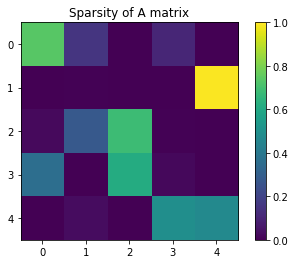

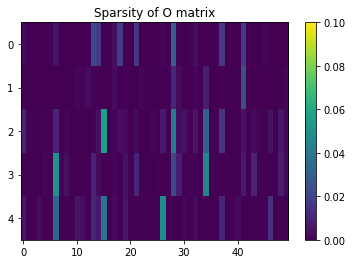

In [ ]:
import requests
import io

response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/r_5_50_A.npy?raw=true')
response.raise_for_status()
loadA = np.load(io.BytesIO(response.content))  
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/r_5_50_O.npy?raw=true')
response.raise_for_status()
loadO = np.load(io.BytesIO(response.content)) 
rhyme_hmm = RhymingHiddenMarkovModel(loadA, loadO,rhyme_array,syl_dict,obs_map,comp_dict)
sonnet = rhyme_hmm.genRhymingSonnet()

visualize_sparsities(rhyme_hmm, O_max_cols=50)

0: See or you and to thing authority
1: Use image words did office I love heaven
2: Whom old found soundless are simplicity
3: Rotten but they the of the sleep of even
4: Less for under make till one toil commend
5: Divide your prove hours hope devour the boast
6: Been me shall to ah to I even then mend
7: Will thee in love long knows lords time birth most
8: Thy time but thee the blunting I cherish
9: Ere of be smell hours more their be when old
10: Return of praise friend believed where perish
11: Many am as bath power prime so most behold
12: Before is those let beauties counterfeit
13: Doth maketh love swears satire do unset


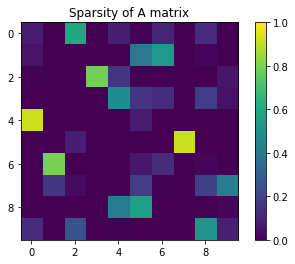

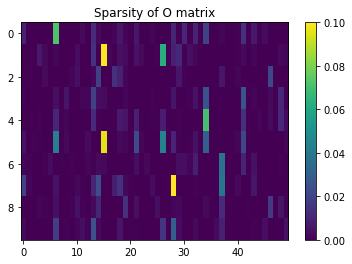

In [ ]:
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/r_10_50_A.npy?raw=true')
response.raise_for_status()
loadA = np.load(io.BytesIO(response.content))  
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/r_10_50_O.npy?raw=true')
response.raise_for_status()
loadO = np.load(io.BytesIO(response.content)) 
rhyme_hmm10 = RhymingHiddenMarkovModel(loadA, loadO,rhyme_array,syl_dict,obs_map,comp_dict)
sonnet = rhyme_hmm10.genRhymingSonnet()

visualize_sparsities(rhyme_hmm10, O_max_cols=50)

0: Blind many wit with have heart truly of cease
1: Alone furrows and am predict sought die
2: Else foul thy transfix pencil gone increase
3: Can you a hand so which they in thereby
4: They many compare as it astonished
5: Long thee the same the determinate side
6: Gaze or the his given chief themselves to dead
7: Worth tired man not and say those sounds horse pride
8: Would frailties thou dearth is outlive make stage
9: Works died befriends ears for plight found commits
10: Assured watching your or true much rage
11: In thy of of farther deaths commence sits
12: One of of jade by with sing with in dead
13: My not mock his from the stop so buried


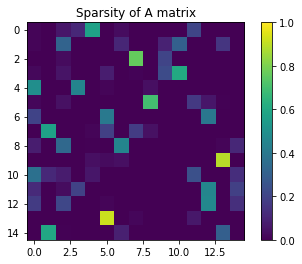

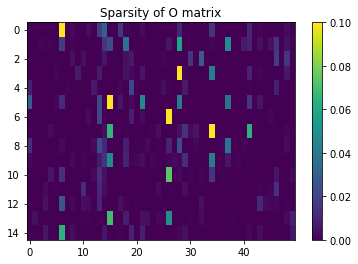

In [ ]:
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/r_15_50_A.npy?raw=true')
response.raise_for_status()
loadA = np.load(io.BytesIO(response.content))  
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/r_15_50_O.npy?raw=true')
response.raise_for_status()
loadO = np.load(io.BytesIO(response.content)) 
rhyme_hmm15 = RhymingHiddenMarkovModel(loadA, loadO,rhyme_array,syl_dict,obs_map,comp_dict)
sonnet = rhyme_hmm15.genRhymingSonnet()

visualize_sparsities(rhyme_hmm15, O_max_cols=50)

0: Tell verse green tattered can thrust him self-killed
1: Mayst being joy farther forget'st discloses
2: Left are with I doth no of o distilled
3: Despair my my losing tie my roses
4: More yellow our we this it fear pleasure
5: Nothing that summers whether world's and confound
6: Of to to and and despite heals treasure
7: Thy your one thy any mine the thine crowned
8: Eye write wide nativity so aside
9: Part skill do like friend souls less whom confounds
10: Therein travel can tops fixed sing far pride
11: Being in guess not aspect thee from I sounds
12: Be firm own and unstained april go
13: Of show than is at kingly wilful-slow


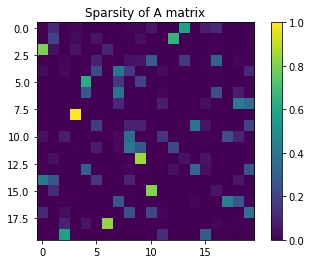

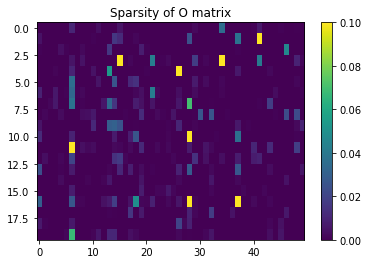

In [ ]:
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/r_20_50_A.npy?raw=true')
response.raise_for_status()
loadA = np.load(io.BytesIO(response.content))  
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/r_20_50_O.npy?raw=true')
response.raise_for_status()
loadO = np.load(io.BytesIO(response.content)) 
rhyme_hmm20 = RhymingHiddenMarkovModel(loadA, loadO,rhyme_array,syl_dict,obs_map,comp_dict)
sonnet = rhyme_hmm20.genRhymingSonnet()

visualize_sparsities(rhyme_hmm20, O_max_cols=50)

# HMM Word Cloud Visualization

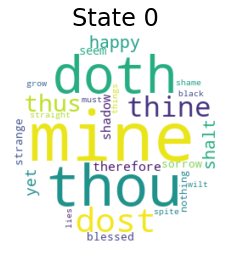

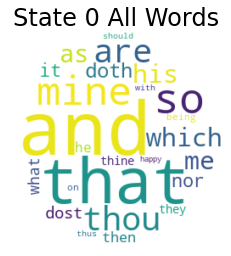

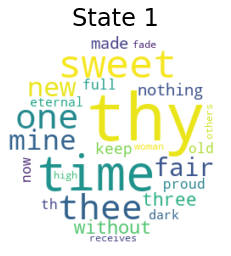

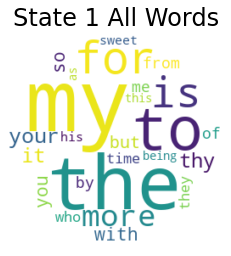

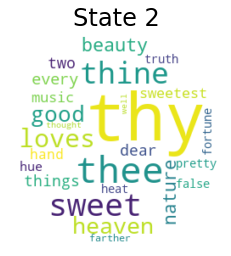

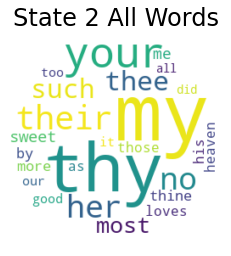

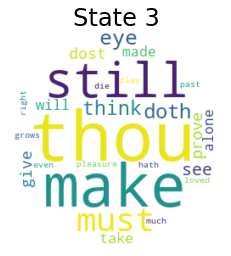

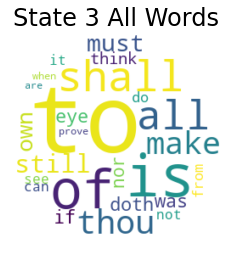

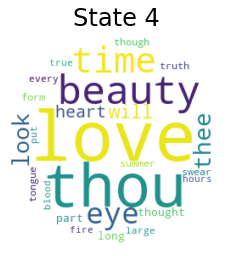

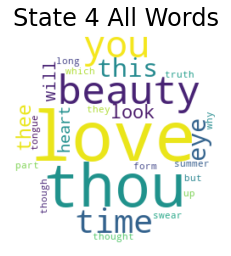

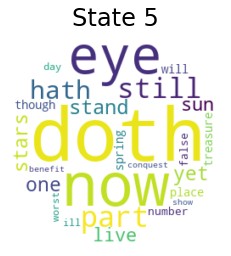

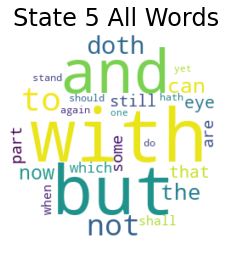

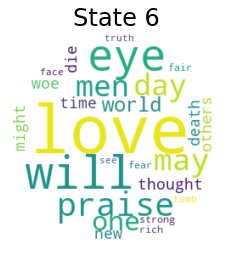

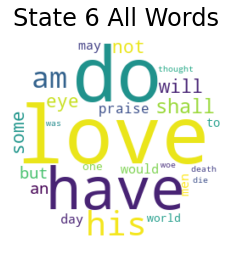

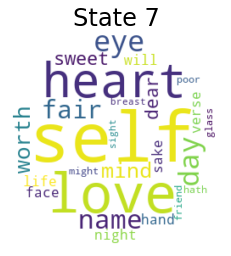

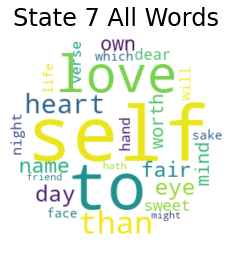

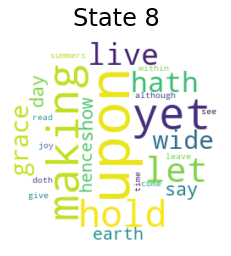

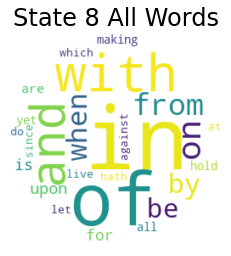

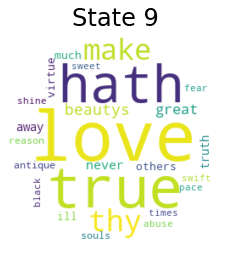

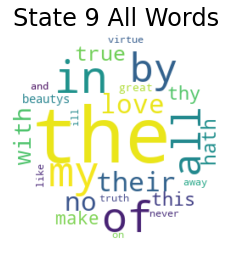

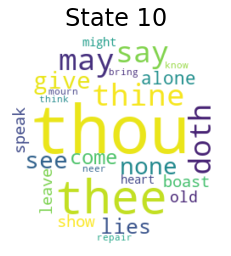

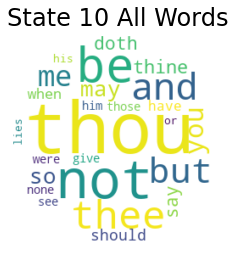

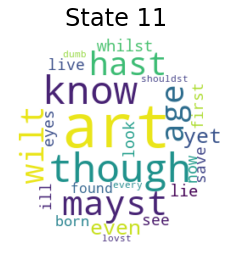

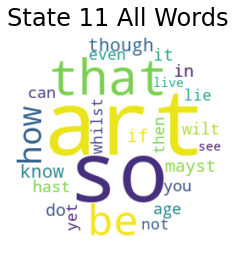

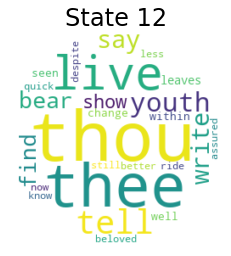

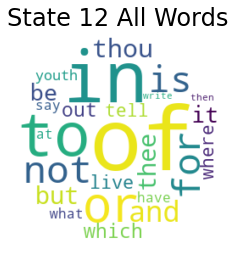

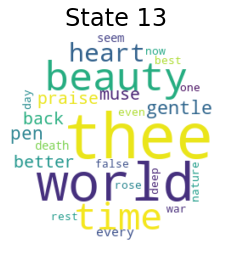

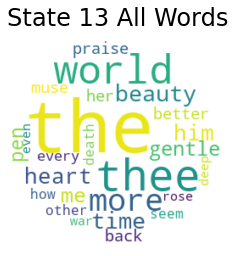

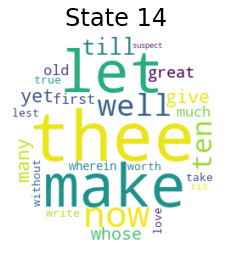

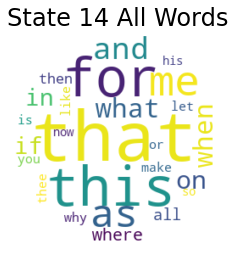

State 0,25 top words: ['and', 'that', 'i', 'so', 'mine', 'are', 'thou', 'which', 'his', 'me', 'as', 'doth', 'it', 'nor', 'dost', 'what', 'then', 'he', 'thine', 'they', 'a', 'being', 'on', 'thus', 'with']
State 1,25 top words: ['i', 'my', 'the', 'a', 'to', 'for', 'is', 'more', 'your', 'it', 'thy', 'so', 'you', 'with', 'but', 'me', 'from', 'by', 'of', 'who', 'they', 'his', 'being', 'this', 'as']
State 2,25 top words: ['my', 'thy', 'your', 'their', 'her', 'no', 'thee', 'such', 'most', 'sweet', 'me', 'by', 'thine', 'more', 'as', 'those', 'his', 'loves', 'good', 'our', 'too', 'it', 'all', 'did', 'them']
State 3,25 top words: ['to', 'is', 'of', 'i', 'shall', 'all', 'thou', 'still', 'must', 'own', 'if', 'doth', 'was', 'nor', 'make', 'eye', 'from', 'think', 'do', 'a', 'not', 'it', 'can', 'see', 'are']
State 4,25 top words: ['love', 'thou', 'beauty', 'you', 'time', 'this', 'eye', 'thee', 'will', 'look', 'heart', 'long', 'but', 'thought', 'part', 'they', 'though', 'truth', 'form', 'swear', 'up',

In [ ]:
from collections import Counter 
def get_top_words(hmm, obs_map, num_words=50, show = True):
    # Initialize.
    max_words = num_words
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []
    wordclouds_all = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)
    # For each state, convert it into a wordcloud.
    sorted_sentence_all = []
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)
        sorted_lst = [key for key, value in Counter(obs_lst).most_common()] #sorted(obs_lst, key = obs_lst.count, reverse=True)
        sorted_sentence = [obs_map_r[j] for j in sorted_lst]
        sorted_sentence_all.append(sorted_sentence)
        # print('State {}, num_words top words:'.format(i))
        # print(sorted_sentence[:num_words])
        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))
        wordclouds_all.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d All Words' % i, show=show, stopwrds= False))
    for i in range(n_states):
      print('State {0},{1} top words: {2}'.format(i,num_words,sorted_sentence_all[i][:num_words]))
    #return wordclouds
        
get_top_words(hmm15, obs_map, 25)

#**RNN model**

Please click on the other colab link in the report

# **Onegin Stanzas**

## HMM stanza generation function

In [ ]:
class StanzaHiddenMarkovModel ( HiddenMarkovModel ):
    '''
    Class implementation of Hidden Markov Models for rhyming sonnets
    '''

    def __init__(self, A, O,syl_dict_stanza,obs_map):
        
        self.syl_dict_stanza = syl_dict_stanza
        self.obs_map = obs_map
        self.obs_map_r = obs_map_reverser(obs_map)
        HiddenMarkovModel.__init__(self,A,O)


    def generate_stanza(self):
        # now generate a random sonnet with 14 lines
        emission = []
        states = []
        syls_per_line = [9,8,9,8,9,9,8,8,9,8,8,9,8,8]

        # make sure we have 14 lines
        line_syls = []
        for i in range(0,14):
          # each line with defined number of syllables
          emission = []
          states = []
          k = 0
          # Initial state
          states.append(np.random.randint(0,self.L))
          emission.append(np.random.choice(self.D,None, True, self.O[states[0],:]))
          #print(self.obs_map_r[emission[0]])
          try:
            syl_count= syl_dict_stanza[self.obs_map_r[emission[0]]]
          except:
            import pdb; pdb.set_trace()
          j=0
          while k<syls_per_line[i]:
            j+=1
            # generate next word
            states.append(np.random.choice(self.L,None, True, self.A[states[j-1],:]))
            emission.append(np.random.choice(self.D,None, True, self.O[states[j],:]))
            syl_count= syl_dict_stanza[self.obs_map_r[emission[j]]]
            #import pdb; pdb.set_trace()
            if k+int(syl_count[0])>syls_per_line[i]:
              # regernerate
              while k+int(syl_count[0])>syls_per_line[i]:
                states[j] = (np.random.choice(self.L,None, True, self.A[states[j-1],:]))
                emission[j] = (np.random.choice(self.D,None, True, self.O[states[j],:]))
                syl_count= syl_dict_stanza[self.obs_map_r[emission[j]]]
            try:
              k+=int(syl_count[0]) # or just pick the first one
            except:
              import pdb; pdb.set_trace()
            #print(k)
            if k>=syls_per_line[i]:
              line_syls.append(k)
          sentence = [self.obs_map_r[i] for i in emission]
          print(' '.join(sentence))
          # break the line after 4/8/12 lines
          if (i == 3 or i == 7 or i == 11):
            print('\n')
        print(line_syls)

## Import Onegin stanza data and create obstacle map

In [ ]:
# Import Data
data_stanza_raw = np.genfromtxt('https://raw.githubusercontent.com/treyra/CS155_miniproject3/main/data/Onegin_sonnet.txt',delimiter='\t',dtype=None,encoding='UTF-8')

In [ ]:
# split line into separate words
data_stanza = [[]]
for i,stanza in enumerate(data_stanza_raw):
    data_stanza[i] = stanza.split()
    if i != len(data_stanza_raw)-1:
        data_stanza.append([])

In [ ]:
# create obs map
count = 0
obs_stanza = []
obs_map_stanza = {}

for line in data_stanza:
  obs_line = []
  for word in line:
    if word not in obs_map_stanza:
      # add new words to the map
      obs_map_stanza[word] = count
      count += 1
    # add the encoded words to the line map
    obs_line.append(obs_map_stanza[word])
      
    # add the encoded sequence
  obs_stanza.append(obs_line)

## Train HMMs

In [ ]:
# train a HMM
hmm5_onegin = unsupervised_HMM(obs_stanza, 5, 50)

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50



### Load the pre-trained models

In [ ]:
# load 5
import requests
import io

response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms_onegin/5_50_A_onegin.npy?raw=true')
response.raise_for_status()
loadA_5_onegin = np.load(io.BytesIO(response.content))  
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms_onegin/5_50_O_onegin.npy?raw=true')
response.raise_for_status()
loadO_5_onegin = np.load(io.BytesIO(response.content)) 

In [ ]:
# load 10
import requests
import io

response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms_onegin/10_50_A_onegin.npy?raw=true')
response.raise_for_status()
loadA_10_onegin = np.load(io.BytesIO(response.content))  
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms_onegin/10_50_O_onegin.npy?raw=true')
response.raise_for_status()
loadO_10_onegin = np.load(io.BytesIO(response.content)) 

In [ ]:
# load 15
import requests
import io

response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms_onegin/15_50_A_onegin.npy?raw=true')
response.raise_for_status()
loadA_15_onegin = np.load(io.BytesIO(response.content))  
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms_onegin/15_50_O_onegin.npy?raw=true')
response.raise_for_status()
loadO_15_onegin = np.load(io.BytesIO(response.content)) 

In [ ]:
# load 20
import requests
import io

response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms_onegin/20_50_A_onegin.npy?raw=true')
response.raise_for_status()
loadA_20_onegin = np.load(io.BytesIO(response.content))  
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms_onegin/20_50_O_onegin.npy?raw=true')
response.raise_for_status()
loadO_20_onegin = np.load(io.BytesIO(response.content)) 

## Creating syllable dictionary for Onegin stanzas

In [ ]:
# get the syllable dictionary for onegin stanzas
!wget https://raw.githubusercontent.com/treyra/CS155_miniproject3/main/data/Onegin_syllables.txt

--2021-03-11 04:32:52--  https://raw.githubusercontent.com/treyra/CS155_miniproject3/main/data/Onegin_syllables.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 141520 (138K) [text/plain]
Saving to: ‘Onegin_syllables.txt’

Onegin_syllables.tx 100%[===================>] 138.20K  --.-KB/s    in 0.03s   

2021-03-11 04:32:52 (5.14 MB/s) - ‘Onegin_syllables.txt’ saved [141520/141520]



In [ ]:
import re
with open('Onegin_syllables.txt', "r") as f:
  syl_data_stanza = f.readlines()

In [ ]:
# remove all ' or " and \n
# remove punctuation
to_remove = ['-', "'"]
for k in range(len(to_remove)):
  for i in range(len(syl_data_stanza)):
    syl_data_stanza[i] = ''.join([j for j in syl_data_stanza[i] if j not in to_remove])
#print(syl_data[0])
for i in range(len(syl_data_stanza)):
  #import pdb; pdb.set_trace()
  syl_data_stanza[i] = syl_data_stanza[i].replace('\n', '')
#print(syl_data[0])
# split the lines into words
for i in range(len(syl_data_stanza)):
  syl_data_stanza[i] = re.findall(r"[\w']+|[.,?;]", syl_data_stanza[i])
#print(syl_data[0])
# make syl_data a dictionary
syl_dict_stanza = dict()
for line in syl_data_stanza:
  #print(line)
  #import pdb; pdb.set_trace()
  syl_dict_stanza.update({line[0]: [line[i] for i in range(1, len(line))]})

## Generate random Onegin stanzas

In [ ]:
hmm5 = StanzaHiddenMarkovModel(loadA_5_onegin, loadO_5_onegin,syl_dict_stanza,obs_map_stanza)
hmm5.generate_stanza()

очаровательных взора жизненных и ночи шпор
в невинных вопервых сквозь ни
ольга вот забредшего письмо и вновь
пьяный слез стихи шиллера иль как


большое обморок внемля если тем за
онегин широкий владелец он к в душой
вопрос строй летают милый буян
луны садит он ей приятный чей


сей то утомлена ли какие
жива жмет слез помню как любовь но
старый с дань ручья живет встречи ним
разъезд об любовью страсти хрустит не


седой иль мух сулили марать сне
не мертвого часы мне любил
[9, 8, 9, 8, 9, 9, 8, 8, 9, 8, 8, 9, 8, 8]


In [ ]:
hmm10 = StanzaHiddenMarkovModel(loadA_10_onegin, loadO_10_onegin,syl_dict_stanza,obs_map_stanza)
hmm10.generate_stanza()

проходит мечтой молдаван был несут с но
читает ее ворота наши дни
посланье мыслит разговоре молебен
женские обесславить поет любви


за видно женщину уголь рано
будучи именье кибитка звон ах в и
гремят полку упоенный и с вдруг
язык мужчин же вперед сем бегут


умной щетиниться и полукот и
верно дворовый в соседа кратком
за сад в выписной кривые не
нет наказу равнять в правилах из


богаты ли мог и нежных на он в чтоб
с я все потужить ж он зима
[9, 8, 9, 8, 9, 9, 8, 8, 9, 8, 8, 9, 8, 8]


In [ ]:
hmm15 = StanzaHiddenMarkovModel(loadA_15_onegin, loadO_15_onegin,syl_dict_stanza,obs_map_stanza)
hmm15.generate_stanza()

души идеальной обильный блеск и
как как евгений или крик и
неверна как блаженные была но нас
вас мир нет дверям судьба beefsteaks


разговор космополитом вечно сменит
занесена без письмо везде какойто как
разовьет него прощай светит уж но
счастлив тем разговору мельницу


милой друг бегут красавиц и любви
и смиренной в шею сладостный
музыка люди любезна дряхлою
отчаяньем и что ищу и двадцать усы


сохранила бабы старине ольги в без
и вот онегиным чинов в ты
[9, 8, 9, 8, 9, 9, 8, 8, 9, 8, 8, 9, 8, 8]


In [ ]:
hmm20 = StanzaHiddenMarkovModel(loadA_20_onegin, loadO_20_onegin,syl_dict_stanza,obs_map_stanza)
hmm20.generate_stanza()

милое сказал которых вы он жизни
долго ножницы как в к думать и но
глуши на вы озеру приводит вот
череп в я цвет всё стоит разговор


своей хранила всем их от как потом
глядит играла всё и же путь по но
мой учились пастух но сына
прошла поправляться на пухлой дай


хронологической равнодушных у светлеет и
татьяна сердце так другие про о
приехав лани досель а цвет таня
в о губ начале и все в вставай


ваш небольшое за да поют
она встречи чужого избе из
[9, 8, 9, 8, 9, 9, 8, 8, 9, 8, 8, 9, 8, 8]


# Haikus

In [ ]:
class HaikuHiddenMarkovModel ( HiddenMarkovModel ):
    '''
    Class implementation of Hidden Markov Models for rhyming sonnets
    '''

    def __init__(self, A, O,syl_dict,obs_map,comp_dict):
        
        self.comp_dict = comp_dict
        self.syl_dict = syl_dict
        self.obs_map = obs_map
        self.obs_map_r = obs_map_reverser(obs_map)
        HiddenMarkovModel.__init__(self,A,O)


    def generate_haiku(self):
        # now generate a random sonnet with 3 lines
        emission = []
        states = []
        syls_per_line = [5,7,5]
        # make sure we have 3 lines
        line_syls = []
        for i in range(0,3):
          emission = []
          states = []
          k = 0
          # Initial state
          states.append(np.random.randint(0,self.L))
          emission.append(np.random.choice(self.D,None, True, self.O[states[0],:]))
          syl_count= syl_dict[self.obs_map_r[emission[0]]]
          if len(syl_count)>1:
            # check to use the one not at the end or just randomly
            not_end_count = [x for x in syl_count if not x.startswith('E')]
            syl_count = not_end_count
          try:
            k+=int(syl_count[0])
          except:
            import pdb; pdb.set_trace()
          j=0
          #print(k)
          while k<syls_per_line[i]:
            j+=1
            # generate next word
            states.append(np.random.choice(self.L,None, True, self.A[states[j-1],:]))
            emission.append(np.random.choice(self.D,None, True, self.O[states[j],:]))
            syl_count= syl_dict[self.obs_map_r[emission[j]]]
            #print(self.obs_map_r[emission[j]])
            if len(syl_count)>1:
              end_count = [x for x in syl_count if x.startswith('E')]
              #import pdb; pdb.set_trace()
              if len(end_count) >= 1:
                if k + int(end_count[0][-1]) > syls_per_line[i]:
                  # if equal to 10 pick this word and save sentence
                  if k + int(end_count[0][-1]) == syls_per_line[i]:
                    syl_count=int(end_count[0][-1])
                # check to use the correct one
                else:
                  for s in syl_count:
                    if s[0]!='E':
                      syl_count = int(s)
              else:
                syl_count = int(syl_count[0])
            else:
              syl_count = int(syl_count[0])
            #import pdb; pdb.set_trace()
            # if type(syl_count) != int:
            #   syl_count = syl_count[0]
            if k+int(syl_count)>syls_per_line[i]:
              # regernerate
              while k+int(syl_count)>syls_per_line[i]:
                states[j] = (np.random.choice(self.L,None, True, self.A[states[j-1],:]))
                emission[j] = (np.random.choice(self.D,None, True, self.O[states[j],:]))
                syl_count= syl_dict[self.obs_map_r[emission[j]]]
                end_count = [x for x in syl_count if x.startswith('E')]
                if len(end_count) >= 1:
                  syl_count=int(end_count[0][-1])
                else:
                  syl_count = int(syl_count[0])
            try:
              k+=syl_count # or just pick the first one
            except:
              import pdb; pdb.set_trace()
            if k>=syls_per_line[i]:
              line_syls.append(k)
          sentence = [self.comp_dict[self.obs_map_r[emission[i]]].capitalize() if i==0 else self.comp_dict[self.obs_map_r[emission[i]]] for i in range(len(emission))]
          print(' '.join(sentence))
        print(line_syls)

In [ ]:
data_sonnet = [[]]
for i,sonnet in enumerate(data_sonnet_raw):
    data_sonnet[i] = sonnet.split()
    if i != len(data_sonnet_raw)-1:
        data_sonnet.append([])

In [ ]:
# create obs map
count = 0
obs = []
obs_map = {}

for line in data_sonnet:
  obs_line = []
  for word in line:
    if word not in obs_map:
      # add new words to the map
      obs_map[word] = count
      count += 1
    # add the encoded words to the line map
    obs_line.append(obs_map[word])
      
    # add the encoded sequence
  obs.append(obs_line)

In [ ]:
# train a HMM (only a few epochs)
hmm5 = unsupervised_HMM(obs, 5, 50)

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50



In [ ]:
hmm5 = HaikuHiddenMarkovModel(hmm5.A, hmm5.O,syl_dict,obs_map,comp_dict)
hmm5.generate_haiku()

Away true him art
Couplement nothing hush thou
Is those them betray
[5, 7, 5]
